# 548 21sp exam2

13.0 <= scores <= 22.0
median score = 19.5


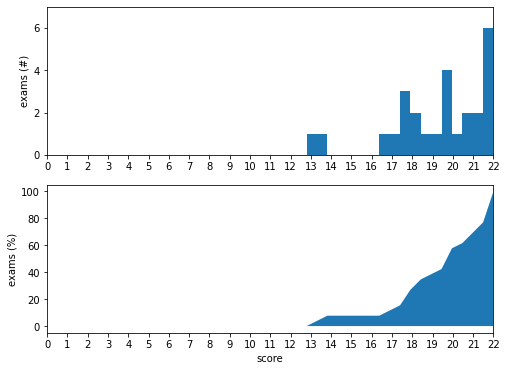

In [1]:
import numpy as np
import pylab as plt

scores = np.array([13, 13.5, 16.5, 17, 17.5, 17.5, 17.75, 18, 18.25, 18.75, 19, 
                   19.5, 19.5, 19.5, 19.5, 20.25, 20.5, 20.5, 21, 21, 21.5, 
                   21.75, 21.75, 21.75, 22, 22])

print('%0.1f <= scores <= %0.1f'%(scores.min(),scores.max()))
print('median score = %0.1f'%np.median(scores))

xlim = (0,22)
dxlim = xlim[1] - xlim[0]

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
h = plt.hist(scores,bins=np.linspace(xlim[0],xlim[1],2*dxlim))
n,s = h[0],h[1]
N = int(np.ceil(h[0].max()))
plt.ylim(0,N+1)
plt.xticks(np.linspace(xlim[0],xlim[1],dxlim+1))
plt.yticks(np.linspace(0,N,(N+2)//2))
plt.xlim(xlim)
plt.ylabel('exams (#)');

plt.subplot(2,1,2)
n *= 100./n.sum()
n = np.hstack((0.,n))
plt.fill_between(s,np.cumsum(n),0*n)
plt.xlim(xlim)
plt.xticks(np.linspace(xlim[0],xlim[1],dxlim+1))
plt.yticks(np.linspace(0,100,6))
plt.xlabel('score'); plt.ylabel('exams (%)');

# setup

In [2]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as animation
from IPython.display import HTML
mpl.rc('animation', html='jshtml')
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


In [4]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [5]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [6]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install slycot
  !pip install control
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

     |████████████████████████████████| 1.6MB 6.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417859 sha256=76146512b7e0168fff7fce7d7d9f6f5f7ff4d74253f8ac36f4e71a98e14ff98a
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot
     |████████████████████████████████| 348kB 7.6MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344929 sha256=7e786d85f61fbd0f87ebc638a8bc2c7a902c085a8fe5347e53279523901dd082
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


# 1. Kalman filtering and smoothing

Consider the noisy process model

$$ x_{s+1} = A_s x_s + B_s u_s + w_s,\ y_s = C_s x_s + v_s, \ x_s \in \mathbb{R}^n,\ u_s \in \mathbb{R}^k, \ y_s \in \mathbb{R}^m, $$

where the initial state is a Gaussian random vector distributed as $\mathcal{N}(x_0,P_0)$ and $w,v$ are independent Gaussian random processes with $w_s\sim\mathcal{N}(0,Q_s)$, $v_s\sim\mathcal{N}(0,R_s)$.

According to [this paper](https://paperpile.com/shared/mbWxcy), the least-squares problem on time horizon $t$

$$ (\text{LS1})\quad \min_{\widehat{x}} \| \widehat{x}_0 - x_0 \|_{P_0^{-1}}^2 + \sum_{s=0}^{t-1} \| \widehat{x}_{s+1} - (A_s \widehat{x}_s + B_s u_s) \|_{Q_s^{-1}}^2 + \sum_{s=1}^t \| y_s - C_s \widehat{x}_s \|_{R_s^{-1}}^2 $$

can equivalently be written in the form

$$ (\text{LS2})\quad \min_{\widehat{x}} \| \xi - A \widehat{x} \|_{Q^{-1}}^2 + \| y - C \widehat{x} \|_{R^{-1}}^2 $$

where $\| z \|_{S^{-1}}^2 = \frac{1}{2} z^\top S^{-1} z$ for any positive-semidefinite matrix $S = S^\top > 0$ and:
* $Q = \operatorname{diag}(P_0,Q_0,Q_1,\dots,Q_{t-1})$,
* $R = \operatorname{diag}(R_1,R_2,\dots,R_t)$,
* $\widehat{x} = \operatorname{vec}(x_0,x_1,\dots,x_t)$,
* $\widehat{y} = \operatorname{vec}(y_1,y_2,\dots,y_t)$,
* $\widehat{\xi} = \operatorname{vec}(x_0,B_0 u_0,B_1 u_1,\dots,B_{t-1} u_{t-1})$,

$$ A = \left[ \begin{array}{cccc} I & 0 & & \\ -A_0 & I & \ddots & \\ & \ddots & \ddots & 0 \\ & & -A_{t-1} & I \end{array} \right],\ C = \left[ \begin{array}{cccc} 0 & C_1 & 0 & \cdots & 0 \\ 0 & 0 & C_2 & \ddots & \vdots \\ \vdots & \vdots & \ddots & \ddots & 0 \\ 0 & 0 & \cdots & 0 & C_t \end{array} \right]. $$




(a) Analytically solve $\text{(LS2)}$ on time horizon $t = 1$ to obtain an expression for $\widehat{x}_1$ in terms of $\widehat{x}_0$ -- you should obtain an expression that appears different from the expression obtained by applying the Kalman filter from the lecture notes with the same problem data, but is in fact equivalent.

## (a) solution

We will make use of the solution $\widehat{x} = (H^\top S^{-1} H)^{-1} H^\top S^{-1} z$ of the weighted least-squares problem $\min_{\widehat{x}} (z - H \widehat{x})^\top S^{-1} (z - H \widehat{x})$ from lecture, since with

$$ S = \operatorname{diag}(P_0, Q_0, R_1),\ z = \left[ \begin{array}{c} x_0 \\ B_0 u_0 \\ y_1 \end{array}\right],\ H = \left[ \begin{array}{cc} I & 0 \\ -A_0 & I \\ 0 & C_1 \end{array}\right] $$

the cost function for $\text{(LS2)}$ can be written as

$$ \| \xi - A \widehat{x} \|_{Q^{-1}}^2 + \| y - C \widehat{x} \|_{R^{-1}}^2 = \frac{1}{2} (z - H \widehat{x})^\top S^{-1} (z - H \widehat{x}). $$

Noting that $\widehat{x} = (H^\top S^{-1} H)^{-1} H^\top S^{-1} z$ is the answer to the question "how can $H^\top S^{-1} z$ be written as a linear combination of the columns of $H^\top S^{-1} H$?", we compute

$$ H^\top S^{-1} z =  \left[ \begin{array}{c} P_0^{-1} x_0 - A_0^\top Q_0^{-1} B_0 u_0 \\ Q_0^{-1} B_0 u_0 + C_1^\top R_1^{-1} y_1 \end{array}\right],\ 
H^\top S^{-1} H = \left[ \begin{array}{c} P_0^{-1} + A_0^\top Q_0^{-1} A_0 & -A_0^\top Q_0^{-1} \\ -Q_0^{-1} A_0 & Q_0^{-1} + C_1^\top R_1^{-1} C_1 \end{array}\right],$$ 

and deduce that $\widehat{x}_0$ and $\widehat{x}_1$ are related by the equation 

$$ Q_0^{-1} B_0 u_0 + C_1^\top R_1^{-1} y_1 = -Q_0^{-1} A_0 \widehat{x}_0 + (Q_0^{-1} + C_1^\top R_1^{-1} C_1) \widehat{x}_1, $$

which equation we solve for $\widehat{x}_1$ in terms of $\widehat{x}_0$ to obtain

$$ \widehat{x}_1 = (Q_0^{-1} + C_1^\top R_1^{-1} C_1)^{-1} \left( Q_0^{-1} (A_0 \widehat{x}_0 + B_0 u_0) + C_1^\top R_1^{-1} y_1 \right). $$

It is not immediately obviuos, but this expression is equivalent to the formula obtained from the Kalman filter, as we will find in subsequent problems.

(b) Implement an algorithm that solves $\text{(LS2)}$ on time horizon $t$ and test the algorithm by comparing the state estimate $\widehat{x}_t$ it produces at the final timestep $t = 8$ (time = $0.8$ sec) with the state estimate obtained by applying the recursive Kalman filter algorithm from the homework 7 solution to the dataset from problem 1(g) with invertible weighting matrix $Q_s = \operatorname{diag}(0.3,0.2)$.

## (b) solution

In [7]:
def kalman_filter(x0,P0,A,B,u,C,Q,R,t_,z_):
  """
  input:
    x0 - d x 1 array; initial state mean
    P0 - d x d array; initial state covariance
    A - func : t -> d x d array; state transition
    B - func : t -> d x m array; control input matrix
    u - func : t -> m x 1 array; control input
    C - func : t -> n x d array; observation matrix
    Q - func : t -> m x m array; input disturbance covariance
    R - func : t -> n x n array; output disturbance covariance
    t_ - N array; times
    z_ - n x N array; noisy observations

  output:
    x_ - d x N array; state estimate
  """
  x_ = [x0]; P_ = [P0]
  for t,zt in zip(t_,z_):
    # State Propagation and prediction
    ti = int(t)-1
    xt_ = np.dot(A(ti),x_[-1]) + np.dot(B(ti),u(ti))
    Pt_ = np.dot(A(ti), np.dot(P_[-1], A(ti).T)) + Q(ti)

    # Update
    K = np.dot(np.dot(Pt_, C(ti).T), la.inv(R(ti) + np.dot(np.dot(C(ti), Pt_), C(ti).T)))
    xt = xt_ + np.dot(K,(zt - np.dot(C(ti), xt_)))
    KC = np.eye(A(ti).shape[0]) - np.dot(K,C(ti))
    Pt = np.dot(np.dot(KC, Pt_), KC.T) + np.dot(np.dot(K,R(ti)),K.T)

    #print(Q(ti),R(ti),u(ti),zt,A(ti),C(ti))

    x_.append(xt)
    P_.append(Pt)
  return np.hstack(x_)

In [8]:
def kalman_smoother(x0,P0,A,B,ut,C,Q,R,t_,z_):
  """
  input:
    x0 - d x 1 array; initial state mean
    P0 - d x d array; initial state covariance
    A - func : t -> d x d array; state transition
    B - func : t -> d x m array; control input matrix
    u - func : t -> m x 1 array; control input
    C - func : t -> n x d array; observation matrix
    Q - func : t -> m x m array; input disturbance covariance
    R - func : t -> n x n array; output disturbance covariance
    t_ - N array; times
    z_ - n x N array; noisy observations

  output:
    x_ - d x N array; state estimate
  """
  Qi_ = [la.inv(P0)]; Ri_ = []; y = []; xi = [x0]
  d = x0.size
  Odxd = np.zeros((d,d))
  Idxd = np.eye(d)
  A_ = [ np.hstack([Idxd] + [Odxd for t in t_]) ]
  C_ = [ ]
  for t,zt in zip(t_,z_):
    ti = int(t)-1
    Qi_.append(la.inv(Q(ti)))
    Ri_.append(la.inv(R(ti+1)))
    y.append(zt)
    xi.append(B(ti) @ u(ti))
    A_.append(np.hstack(([Odxd for s in np.arange(0,ti+1)] + [-A(ti)] + [Idxd] 
                         + [Odxd for s in np.arange(ti+2,t_.size)])))
    n = C(ti).shape[0]
    Onxd = np.zeros((n,d))
    C_.append(np.hstack(([Onxd for s in np.arange(0,ti+2)] + [C(ti)] 
                         + [Onxd for s in np.arange(ti+2,t_.size)])))
    #print(Q(ti),R(ti),u(ti),zt,A(ti),C(ti))
  Qi_ = la.block_diag(*Qi_)
  Ri_ = la.block_diag(*Ri_)
  y = np.vstack(y)
  xi = np.vstack(xi)
  A_ = np.vstack(A_)
  C_ = np.vstack(C_)
  #return Qi_,Ri_,y,xi,A_,C_

  M = np.vstack(( A_.T @ Qi_ @ A_ + C_.T @ Ri_ @ C_ ))
  b = np.vstack(( A_.T @ Qi_ @ xi + C_.T @ Ri_ @ y ))

  return la.lstsq(M,b)[0].reshape(x0.size,t_.size+1,order='F')

In [9]:
url = 'https://raw.githubusercontent.com/sburden/548-20sp/master/548_20sp_hw7tuz.csv'
import pandas as pd
import numpy as np
data = np.asarray(pd.read_csv(url,header=None))

g,length,mass = 9.81,.5,1. # m/sec^2, m, kg
delta = 0.1
A = np.asarray([[0.0,1.0],[-g/length,0.0]])
B = np.asarray([[0.0],[1/(mass*length**2)]])
C = np.asarray([[1.0, 0.0]])
A_d = la.expm(A * delta)
B_d = np.dot(np.dot(A_d - np.eye(A.shape[0]), la.inv(A)), B)
C_d = C

x0 = np.array([[-0.14415834],[ 0.23380803]])
P0 = np.array([[ 0.1, 0. ],[ 0., 1. ]])

t_, u_, z_ = data[:,0], data[:,1], data[:,2] 

A = lambda t: A_d
B = lambda t: B_d
C = lambda t: C_d
R = lambda t: np.array([[0.1]])
Q = lambda t: np.asarray([[0.3,0.0],[0.0,0.2]])
u = lambda t: np.array([[u_[t]]])

In [10]:
T = 8
#Q_,R_,y,xi,A_,C_ = kalman_smoother(x0,P0,A,B,u,C,Q,R,t_[:T],z_[:T])
x_filter = kalman_filter(x0,P0,A,B,u,C,Q,R,t_[:T],z_[:T])
x_smoother = kalman_smoother(x0,P0,A,B,u,C,Q,R,t_[:T],z_[:T])

print(x_filter)
print(x_smoother)

[[-0.144 -0.139 -0.094 -0.028  0.054  0.113  0.124  0.103  0.037]
 [ 0.234  0.417  1.111  1.33   1.044  0.362 -0.477 -1.17  -1.535]]
[[-0.15  -0.148 -0.11  -0.041  0.046  0.113  0.136  0.117  0.037]
 [ 0.21   0.397  1.106  1.359  1.106  0.443 -0.4   -1.129 -1.535]]


Text(0, 0.5, 'state estimate')

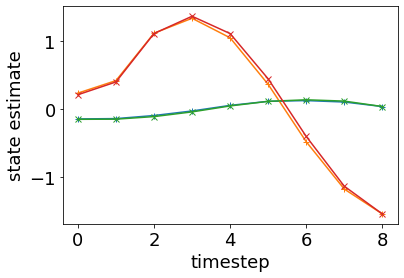

In [20]:
plt.figure()
plt.plot(x_filter.T,'-+')
plt.plot(x_smoother.T,'-x')
plt.xlabel('timestep')
plt.ylabel('state estimate')

(c) You should find in (a) and (b) that the state estimate obtained by solving $\text{(LS2)}$ is different from the state estimate obtained by applying the Kalman filter with the same problem data at all times ***other than the final time*** (i.e. at time $0$ in (a) and times $0, 1, \dots, t-1$ in (b)) -- explain in plain language why these two solutions are different.

***Hint:*** the solution to $\text{(LS2)}$ is often referred to as the "Kalman smoother" -- this information may help when searching technical materials.

## (c) solution

The state estimates $\widehat{x}_s$ obtained by solving $(\text{LS2})$ are ***acausal*** in that they are informed by the observations at ***all*** times, including ***future*** times, whereas the Kalman filter estimates are ***causal*** in that they are determined only by observations at previous and present times -- in plain language:  if you knew what the state was going to be in the future, that information could be used to improve your estimate of the state in the present.  There is no distinction at the final time since (by definition) there are no future observations, so the two estimates for $\widehat{x}_t$ coincide.  

# 2. optimal reference tracking

Consider the process model

$$ (\text{LTV})\quad x_{s+1} = A_s x_s + B_s u_s,\ x_s \in \mathbb{R}^n,\ u_s \in \mathbb{R}^k. $$

We'll call signal $\bar{x}:[0,\infty)\rightarrow\mathbb{R}^n$ a ***reference trajectory*** for $(\text{LTV})$ if there exists a corresponding ***reference input*** $\bar{u}:[0,\infty)\rightarrow\mathbb{R}^k$ such that

$$ \forall s\in[0,\infty) : \bar{x}_{s+1} = A_s \bar{x}_s + B_s \bar{u}_s. $$

(a) Supposing that $\bar{x}$ is a reference trajectory with reference input $\bar{u}$ for $(\text{LTV})$, design a reference-tracking controller by minimizing the following cost:

$$ \sum_{s=0}^t \| x(s) - \bar{x}(s) \|^2 + \| u(s) - \bar{u}(s) \|^2. $$

***Hint:*** you should find that the optimal controller is a linear combination of two terms: a *feedforward* term that varies with time (only) and a *feedback* term that varies with state and time.



## (a) solution

The optimal control $u^*(t,x) = u_{FF}(t) + u_{FB}(x)$ consists of a *feedforward* term $u_{FF}(t) = \bar{u}(t)$ and a *feedback* term $u_{FB}(s,x) = - K_s (x - \bar{x}_s)$, where $K$ is the time-varying gain matrix obtained by solving the Linear-Quadratic Regulation problem with $Q = I$, $R = I$.

To see why this is optimal, consider the relative coordinates for state and input $\delta x_s = x_s - \bar{x}_s$, $\delta u_s = u_s - \bar{u}_s$.  In these coordinates, the dynamics are

$$ \delta x_{s+1} = x_{s+1} - \bar{x}_{s+1} = A x_s + B u_s - (A_s \bar{x}_s + B_s \bar{u}_s) $$

$$ = A_s (x_s - \bar{x}_s) + B_s (u_s - \bar{u}_s) = A_s \delta x_s + B_s \delta u_s,$$

and the cost is $\sum_{s=0}^t \delta x_s^\top \delta x_s + \delta u_s^\top \delta u_s$.  If $\delta x_0 = 0$, i.e. $x_0 = \bar{x}_0$, then the optimal input to apply is $\bar{u}$.  If $\delta x_0 \neq 0$ then the optimal input to apply is a linear combination of *feedforward* input $\bar{u}$ and *feedback* input $- K_s \delta x_s$ where $K$ is the time-varying gain matrix obtained by solving the Linear-Quadratic Regulation problem with $Q = I$, $R = I$.

(b) Implement an algorithm that (i) determines whether a given signal $\bar{x}:[0,\infty)\rightarrow\mathbb{R}^n$ is a reference trajectory for $(\text{LTV})$ on time horizon $t$ and (ii) if so, computes a corresponding $\bar{u}$.  Explain in plain language how your algorithm works, and provide your implementation using the following function signature:

In [ ]:
def reference_tracking(A_,B_,x_,t):  """
  input:
    A_ - length-t list of n x n arrays; state matrix
    B_ - length-t list of n x k arrays; control matrix
    x_ - length-t list of length-n arrays; reference
    t - integer > 0; time horizon

  output:
    is_reference - Boolean; 
    u_ - depends on truth value of is_reference:
      if True then length-(t-1) list of length-k arrays
      if False then None
  """
  # determine whether x_ is a reference for A_, B_ on time horizon t
  if is_reference:
    # compute u_
    return True,u_
  else:
    return False,None

## (b) solution

The condition for $\bar{x}$ to be a reference trajectory is 

$$ \forall s\in[0,\infty) : \bar{x}_{s+1} = A_s \bar{x}_s + B_s \bar{u}_s, $$

which can equivalenly be written as

$$ \forall s\in[0,\infty) : \bar{x}_{s+1} - A_s \bar{x}_s \in \mathcal{R}(B_s), $$

where $\mathcal{R}(B_s)$ denotes the *range space* (also known as *column space* or *span*) of matrix $B_s$.  Since the rank-nullity Theorem tells us that the range space of a matrix is equal to the orthogonal complement of its *null space* $\mathcal{N}$,

$$ \mathcal{R}(B_s) = \mathcal{N}(B_s)^\perp, $$

we can assess whether a given signal is a reference trajectory for a given system simply by checking the condition 

$$ B_s^\top (\bar{x}_{s+1} - A_s \bar{x}_s) = 0, $$

which we implement in code as `np.allclose( B[s].T @ (x[s+1] - A[s] @ x[s]), 0)`.

(c) Determine whether the following signals are reference trajectories for the given systems (you may use your algorithm from (b) or use pen-and-paper analysis):

(c.i) constant signal $\bar{x}(s) = r$ with $r \neq 0$ for first-order system $\dot{y} = u$;

(c.ii) constant signal $\bar{x}(s) = (q,p)$ with $q$ ***and*** $p$ nonzero for second-order system $\ddot{y} = u$.

## (c) solution

The condition from (b) for a signal to be a reference trajectory was that $\bar{x}_{s+1} - A \bar{x}_{s}$ lies in the rangespace of $B_s$ -- we will use this condition to solve the following problems.

(c.i) With $x = y$ we have $\dot{x} = a x + b u$ where $a = 0$, $b = 1$; since $b$ is nonzero and $x$ is one-dimensional, every constant reference $\bar{x} \equiv r$ is in the range of $b$.

(c.ii) with $x = (y,\dot{y})$ we have $\dot{x} = (\dot{y}, \ddot{y}) = A x + B u$ where 

$$ A = \left[ \begin{array}{cc} 0 & 1 \\ 0 & 0 \end{array} \right],\ B = \left[ \begin{array}{cc} 0 \\ 1 \end{array} \right]. $$

Since $\mathcal{R}(B)$ spans $\dot{y}$ it is possible to have a constant reference $\bar{x} \equiv (0,p)$, but it is not possible to have a constant reference $\bar{x} \equiv (q,p)$ with $q$ and $p$ nonzero.

# 3. fragile vs robust control

Consider the following example from [Doyle's 1978 paper](https://paperpile.com/shared/BRx9bl):

$$
\dot{x}
=
\left[ \begin{array}{c} 1 & 1 \\ 0 & 1 \end{array} \right]
x
+
\left[ \begin{array}{c} 0 \\ 1 \end{array} \right]
u
+
\left[ \begin{array}{c} 1 \\ 1 \end{array} \right]
w,
$$

$$
y = 
\left[ \begin{array}{c} 1 & 0 \end{array} \right] x + v,
$$

where:
$x\in\mathbb{R}^2$ is the state, 
$u\in\mathbb{R}$ is the control input, 
$w\in\mathbb{R}$ is the input disturbance, 
and
$v\in\mathbb{R}$ is the output disturbance.

Assume $w$ and $v$ are independent Gaussian random processes with variances $\operatorname{Var}[w] = \sigma^2 > 0$ and $\operatorname{Var}[v] = 1$, and suppose the error vector to be minimized is $z = (\sqrt{q}\, (x_1 + x_2), u)$ where $q > 0$ is a weighting parameter.



(a) *Regarding this LTI system as a process $P$ with inputs $\bar{w} = (\frac{1}{\sigma} w,v),u$, outputs $z,y$, state $x$, determine the system matrices for the following state-space representation of $P$:*

$$
\dot{x} = A x + B_1 \bar{w} + B_2 u,\\
z = C_1 x + D_{11} \bar{w} + D_{12} u,\\
y = C_2 x + D_{21} \bar{w} + D_{22} u.
$$

***Solve the following problems using multiple choices of the parameter $q = \sigma^2$.***



## (a) solution

$$
A = \left[ \begin{array}{cc} 1 & 1 \\ 0 & 1 \end{array} \right],\
B_1 = \left[ \begin{array}{cc} \sigma & 0 \\ \sigma & 0 \end{array} \right],\
B_2 = \left[ \begin{array}{c} 0 \\ 1 \end{array} \right],
$$

$$
C_1 = \left[ \begin{array}{cc} \sqrt{q} & \sqrt{q} \\ 0 & 0 \end{array} \right],\
D_{11} = \left[ \begin{array}{cc} 0 & 0 \\ 0 & 0 \end{array} \right],\
D_{12} = \left[ \begin{array}{c} 0 \\ 1 \end{array} \right],
$$

$$
C_2 = \left[ \begin{array}{cc} 1 & 0 \end{array} \right],\
D_{21} = \left[ \begin{array}{cc} 0 & 1 \end{array} \right],\
D_{22} = 0.
$$

(b) Use `control.h2syn`, i.e. the $H_2$ controller synthesis routine from the Control Systems Toolbox, to determine a dynamic compensator $C_{H_2}$ for $P$ that minimizes the $H_2$ norm of the closed-loop transformation from $w$ to $z$.

***Hint:*** use the following arguments to `h2syn`: `P = ctrl.ss(A,B,C,D)`, `nmeas = 1`, `ncont = 1` where

$$
B = \left[ \begin{array}{c} B_1 & B_2 \end{array} \right],\
C = \left[ \begin{array}{cc} C_1 \\ C_2 \end{array} \right],\
D = \left[ \begin{array}{cc} D_{11} & D_{12} \\ D_{21} & D_{22} \end{array} \right].
$$

Provide code that verifies your answer agrees with the continuous-time infinite-horizon LQG = LQ + KF regulator when the LQ weighting matrices are $Q = C_1^\top C_1$, $R = 1$ and the KF weighting matrices are $W = B_1 B_1^\top$, $V = 1$, and provide a plot of the gain margin $g_m$ of the closed-loop system as a function of $q = \sigma^2$.

***Hint:*** use the `control.lqr` function.

## (b) solution

In [ ]:
def h2syn(s2): # s2 = sigma^2
  q = s2 # q

  # dx = A x + B1 w + B2 u
  A = np.array([[1,1],[0,1]])
  B1 = np.array([[np.sqrt(s2),0],[np.sqrt(s2),0]])
  B2 = np.array([[0],[1]])
  # z = C1 x + D11 w + D12 u
  C1 = np.array([[np.sqrt(q),np.sqrt(q)],[0,0]])
  D11 = np.zeros((2,2))
  D12 = np.array([[0],[1]])
  # y = C2 x + D21 w + D22 u
  C2 = np.array([[1,0]])
  D21 = np.array([[0,1]])
  D22 = np.zeros((1,1))

  # check shapes
  P_zw = ctrl.ss(A,B1,C1,D11)
  P_zu = ctrl.ss(A,B2,C1,D12)
  P_yw = ctrl.ss(A,B1,C2,D21)
  P_yu = ctrl.ss(A,B2,C2,D22)

  # assemble overall P
  B = np.hstack((B1,B2))
  C = np.vstack((C1,C2))
  D1 = np.hstack((D11,D12))
  D2 = np.hstack((D21,D22))
  D = np.vstack(( D1, D2 ))

  P = ctrl.ss(A,B,C,D)

  nmeas = 1; ncont = 1;
  C_H2 = ctrl.h2syn(P,nmeas,ncont)
  #print('C_H2:\n',C_H2)

  # LQ 
  Q = C1.T @ C1
  R = np.ones((1,1))
  K = ctrl.lqr(A,B2,Q,R)[0]

  # KF
  W = B1 @ B1.T
  V = np.ones((1,1))
  L = ctrl.lqr(A.T,C2.T,W,V)[0].T

  # LQG = LQ + KF
  C_LQG = ctrl.ss(A - B2 @ K - L @ C2, L, -K, np.zeros((1,1)))
  #print('C_LQG:\n',C_LQG)

  assert np.allclose(C_H2.A,C_LQG.A)
  assert np.allclose(C_H2.B,C_LQG.B)
  assert np.allclose(C_H2.C,C_LQG.C)
  assert np.allclose(C_H2.D,C_LQG.D)

  return C_H2

Including three variants of the plot, depending on whether a linear or log scale is used for the horizontal or vertical axes:

Text(0.5, 0, 'noise / penalty parameter $\\sigma^2 = q$')

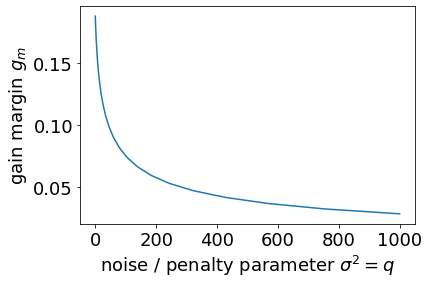

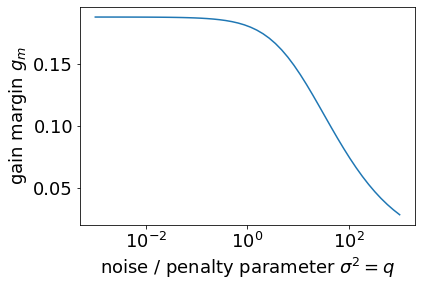

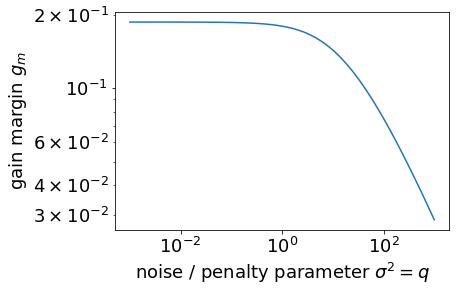

In [ ]:
S2 = np.logspace(-3,3)
Gm = np.array([ctrl.margin(h2syn(s2))[0] for s2 in S2])

plt.figure()
plt.plot(S2,Gm)
plt.ylabel(r'gain margin $g_m$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

plt.figure()
plt.semilogx(S2,Gm)
plt.ylabel(r'gain margin $g_m$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

plt.figure()
plt.loglog(S2,Gm)
plt.ylabel(r'gain margin $g_m$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

#plt.tight_layout();

(c) Use `control.hinfsyn`, i.e. the $H_\infty$ controller synthesis routine from the Control Systems Toolbox, to determine a dynamic compensator $C_{H_\infty}$ for $P$ that minimizes the $H_\infty$ norm of the closed-loop transformation from $w$ to $z$; provide a state-space realization of the compensator.  Provide a plot of the $H_\infty$ norm versus $q = \sigma^2$.



## (c) solution

In [ ]:
def hinfsyn(s2): # s2 = sigma^2
  q = s2 # q

  # dx = A x + B1 w + B2 u
  A = np.array([[1,1],[0,1]])
  B1 = np.array([[np.sqrt(s2),0],[np.sqrt(s2),0]])
  B2 = np.array([[0],[1]])
  # z = C1 x + D11 w + D12 u
  C1 = np.array([[np.sqrt(q),np.sqrt(q)],[0,0]])
  D11 = np.zeros((2,2))
  D12 = np.array([[0],[1]])
  # y = C2 x + D21 w + D22 u
  C2 = np.array([[1,0]])
  D21 = np.array([[0,1]])
  D22 = np.zeros((1,1))

  # check shapes
  P_zw = ctrl.ss(A,B1,C1,D11)
  P_zu = ctrl.ss(A,B2,C1,D12)
  P_yw = ctrl.ss(A,B1,C2,D21)
  P_yu = ctrl.ss(A,B2,C2,D22)

  # assemble overall P
  B = np.hstack((B1,B2))
  C = np.vstack((C1,C2))
  D1 = np.hstack((D11,D12))
  D2 = np.hstack((D21,D22))
  D = np.vstack(( D1, D2 ))

  P = ctrl.ss(A,B,C,D)

  nmeas = 1; ncont = 1;
  C_oo,_,H_oo,_ = ctrl.hinfsyn(P,nmeas,ncont)

  return C_oo,H_oo

In [ ]:
ctrl.hinfsyn?

Text(0.5, 0, 'noise / penalty parameter $\\sigma^2 = q$')

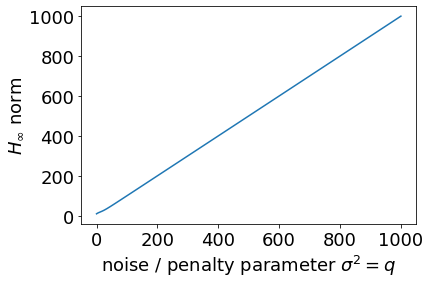

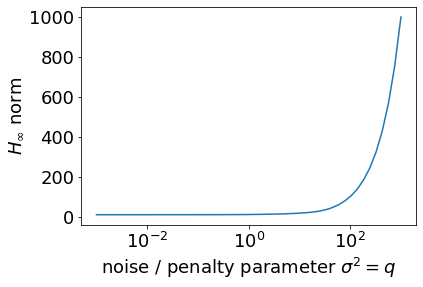

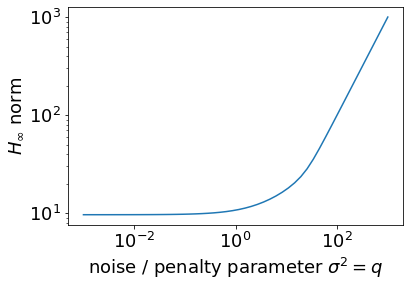

In [ ]:
H_oo = np.array([hinfsyn(s2)[1] for s2 in S2])

plt.figure()
plt.plot(S2,H_oo)
plt.ylabel(r'$H_{\infty}$ norm')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

plt.figure()
plt.semilogx(S2,H_oo)
plt.ylabel(r'$H_{\infty}$ norm')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

plt.figure()
plt.loglog(S2,H_oo)
plt.ylabel(r'$H_{\infty}$ norm')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')

#plt.tight_layout();

(d) Apply the ("small-gain") Theorem from lecture 09c ("uncertain systems") to determine a bound on the gain margin based on the $H_\infty$ norm computed in (c) and compare to the actual gain margin.  Provide a plot showing the gain margin and its bound versus $q = \sigma^2$.


## (d) solution

In [ ]:
Gm = np.array([ctrl.margin(hinfsyn(s2)[0])[0] for s2 in S2])

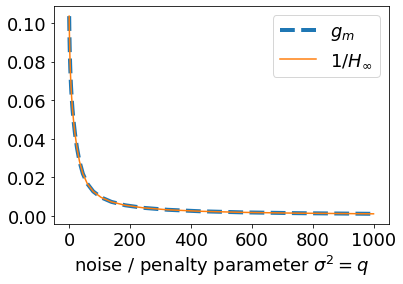

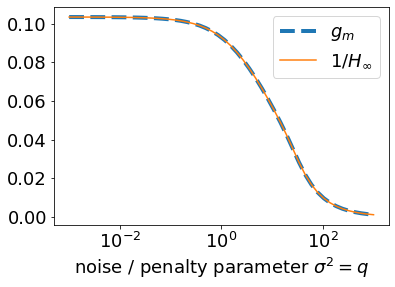

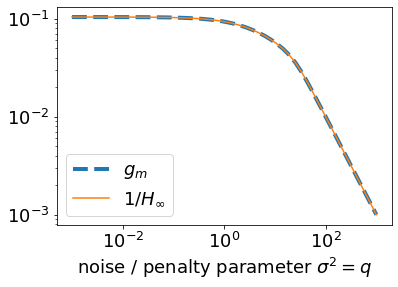

In [ ]:
plt.figure()
plt.plot(S2,Gm,'--',lw=4,label=r'$g_m$')
plt.plot(S2,1/H_oo,label=r'$1/H_{\infty}$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')
plt.legend()

plt.figure()
plt.semilogx(S2,Gm,'--',lw=4,label=r'$g_m$')
plt.semilogx(S2,1/H_oo,label=r'$1/H_{\infty}$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')
plt.legend()

plt.figure()
plt.loglog(S2,Gm,'--',lw=4,label=r'$g_m$')
plt.loglog(S2,1/H_oo,label=r'$1/H_{\infty}$')
plt.xlabel(r'noise / penalty parameter $\sigma^2 = q$')
plt.legend()